In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import math

from pycox.datasets import metabric, gbsg, support
from lifelines import KaplanMeierFitter
import scipy.fft as fft

#local scripts
import preprocessing as pp
import centralizedDP as cdp
import federatedKM as fdk
import helpers as h
import evaluation.evaluation as ev
import evaluation.plots as plots

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [3]:
np.random.seed(1234)

In [4]:
# plt.step(bins, y[:-1], label="original")
# plt.step(bins, noisy_y[:-1], label="w noise")
# plt.show()

## Centralized Experiments

In [13]:
#import datasets
name = "gbsg"
df_init = support.read_df()
df_init = df_init[["duration", "event"]]
_, df = h.event_seperator(df_init)
max_duration = (df["duration"].max())
print(f'max duration: {max_duration}')
total_number = len(df)
print(f'total number of data points: {total_number}')

max duration: 1944.0
total number of data points: 6036


In [17]:
#import datasets
name = "metabric"
df = metabric.read_df()
df = df[["duration", "event"]]
df2, df1 = h.event_seperator(df)
max_duration = (df["duration"].max())
print(f'max duration: {max_duration}')
total_number = len(df)
print(f'total number of data points: {total_number}')

max duration: 355.20001220703125
total number of data points: 1904


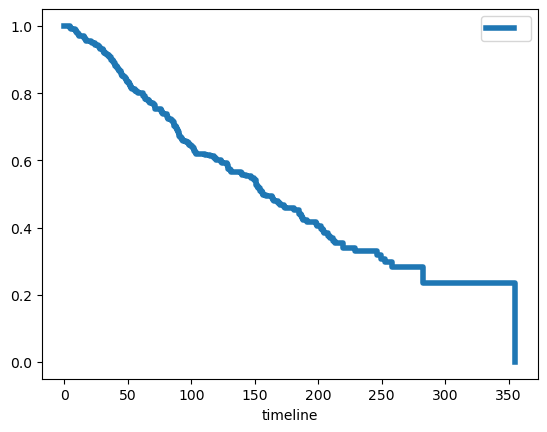

In [48]:
ax = plt.subplot(111)
kmf = KaplanMeierFitter()
a = kmf.fit(df[1:300]["duration"], df[1:300]["event"])
a.plot(ci_show=False, label="", linewidth=4.0)

# ds1 = kmf.fit(df1["duration"], df1["event"], label=f"Drug A")
# ds1 = kmf.fit(df_init["duration"], df_init["event"], label=f"Drug B")
# ds1.plot()
# ax.set_xlabel("Time", fontsize="large")
# ax.set_ylabel("Survival Probability", fontsize="large")
# leg1 = ax.legend()
# ax.add_artist(leg1)
plt.savefig(f'figs/toy-all.jpg', dpi=300, bbox_inches="tight")
plt.show()


In [110]:
dp_surv_bins= {"support":2, "gbsg":1, "metabric":6}
dp_prob_bins= {"support":6, "gbsg":2, "metabric":4}
dp_matrix_bins= {"support":6, "gbsg":2, "metabric":6}

In [111]:
max_time = math.floor(max_duration)
epsilon = 10
frac = 0.10

In [112]:
point1 = np.floor(0.25*max_duration)
point2 = np.floor(0.50*max_duration)
point3 = np.floor(0.75*max_duration)
print(f'first time= {point1}, second time={point2}, third time={point3}')
tarr = [point1, point2, point3]

first time= 88.0, second time=177.0, third time=266.0


In [113]:
#info of original dataset
survival, upper, lower = ev.confidence_at_time(df, tarr)
median, median_ci = ev.median_confidence(df)
print("survival at times:", survival)
print("upper confidence:", upper)
print("lower confidence:", lower)
print("median:", median, "median_ci:", median_ci)

survival at times: [0.69 0.44 0.24]
upper confidence: [0.71, 0.47, 0.27]
lower confidence: [0.67, 0.42, 0.21]
median: 154 median_ci: [[  0.5        146.3999939  167.93333435]]


In [114]:
p_surv, m_surv, sr_surv = [], [], []

In [115]:
print("DP-Surv worst case")
for i in range(10): 
    s_inst = cdp.CentralizedDPS(df, dp_surv_bins[name], max_time, frac, epsilon)
    surrworst, _, _, _ = s_inst.DP_Surv_worst()
#     p, m , sr = ev.centralized_ex(df, surrworst, tarr)
#     p_surv+=[p]
#     m_surv+=[m]
#     sr_surv+=[sr]
# print("p-value:", ev.confidence_of_mean(p_surv))
# print("median:", ev.confidence_of_mean(m_surv))
# print("survival rates", ev.confidence_of_mean(sr_surv))

DP-Surv worst case


In [116]:
p_matrix, m_matrix, sr_matrix = [], [], []

In [117]:
print("DP-Matrix+")
for i in range(10): 
    surrmat, _ = cdp.DP_matrix(df, dp_matrix_bins[name], max_time, epsilon)
    p, m , sr = ev.centralized_ex(df, surrmat, tarr)
    # p_matrix+=[p]
    # m_matrix+=[m]
    # sr_matrix+=[sr]
# print("p-value:", ev.confidence_of_mean(p_matrix))
# print("median:", ev.confidence_of_mean(m_matrix))
# print("survival rates:", ev.confidence_of_mean(sr_matrix))

DP-Matrix+


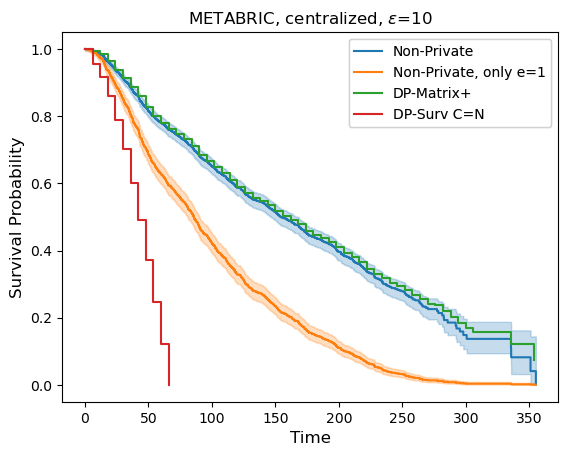

In [118]:
title = "centralized"
ax = plt.subplot(111)
kmf = KaplanMeierFitter()
a = kmf.fit(df["duration"], df["event"], label=f"Non-Private")
a.plot()

ds1 = kmf.fit(df1["duration"], df1["event"], label=f"Non-Private, only e=1")
ds1.plot()

dpmat = kmf.fit(surrmat["duration"], surrmat["event"], label=f"DP-Matrix+")
dpmat.plot(ci_force_lines=False, ci_show=False, linestyle="-")

dpp = kmf.fit(surrworst["duration"], surrworst["event"], label=f"DP-Surv C=N")
dpp.plot(ci_force_lines=False, ci_show=False, linestyle="-")



ax.set_title(f"{name.upper()}, {title}, $\epsilon$={epsilon}")
ax.set_xlabel("Time", fontsize="large")
ax.set_ylabel("Survival Probability", fontsize="large")
leg1 = ax.legend()
ax.add_artist(leg1)
plt.savefig(f'figs/2casewdpmat-{name}-{title}-e{epsilon}.pdf', dpi=300, bbox_inches="tight")
plt.show()

In [41]:
p_surv, m_surv, sr_surv = [], [], []

In [42]:
print("DP-Surv")
for i in range(10): 
    s_inst = cdp.CentralizedDPS(df, dp_surv_bins[name], max_time, frac, epsilon)
    surrsurv, _, _, _ = s_inst.DP_Surv()
    p, m , sr = ev.centralized_ex(df, surrsurv, tarr)
    p_surv+=[p]
    m_surv+=[m]
    sr_surv+=[sr]
print("p-value:", ev.confidence_of_mean(p_surv))
print("median:", ev.confidence_of_mean(m_surv))
print("survival rates", ev.confidence_of_mean(sr_surv))

DP-Surv
p-value: (0.25, array([0.04, 0.45]))
median: (213.8, array([ 76.99, 310.  ]))
survival rates (array([0.4 , 0.27, 0.24]), array([[0.37, 0.24, 0.22],
       [0.44, 0.3 , 0.25]]))


In [9]:
p_prob, m_prob, sr_prob = [], [], []

In [10]:
print("DP-Prob")
for i in range(100): 
    p_inst= cdp.CentralizedDPy(df, dp_prob_bins[name], max_time, epsilon)
    surrprob, _, _, _ = p_inst.DP_probs()
    p, m , sr = ev.centralized_ex(df, surrprob, tarr)
    p_prob+=[p]
    m_prob+=[m]
    sr_prob+=[sr]
print("p-value:", ev.confidence_of_mean(p_prob))
print("median:", ev.confidence_of_mean(m_prob))
print("survival rates:", ev.confidence_of_mean(sr_prob))

DP-Prob
p-value: (0.0, array([0., 0.]))
median: (66.84, array([66.24, 67.44]))
survival rates: (array([0.17, 0.08, 0.03]), array([[0.17, 0.08, 0.03],
       [0.18, 0.08, 0.03]]))


In [13]:
p_matrix, m_matrix, sr_matrix = [], [], []

In [14]:
print("DP-Matrix+")
for i in range(10): 
    surrmat, _ = cdp.DP_matrix(df, dp_matrix_bins[name], max_time, epsilon)
    p, m , sr = ev.centralized_ex(df, surrmat, tarr)
    p_matrix+=[p]
    m_matrix+=[m]
    sr_matrix+=[sr]
print("p-value:", ev.confidence_of_mean(p_matrix))
print("median:", ev.confidence_of_mean(m_matrix))
print("survival rates:", ev.confidence_of_mean(sr_matrix))

DP-Matrix+
p-value: (0.07, array([-0.05,  0.14]))
median: (60.0, array([60., 60.]))
survival rates: (array([0.12, 0.  , 0.  ]), array([[ 0.12, -0.  , -0.  ],
       [ 0.13,  0.  ,  0.  ]]))


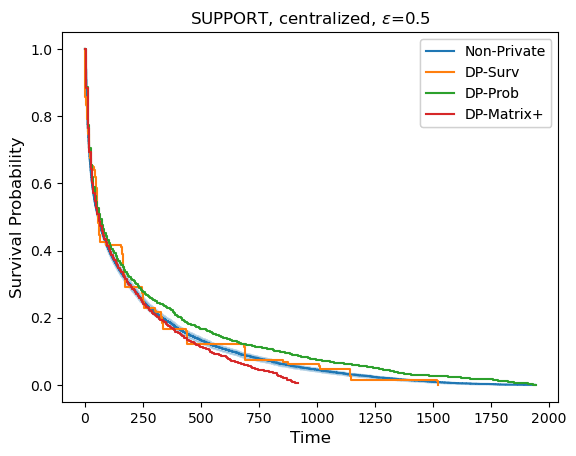

In [15]:
title = "centralized"
ax = plt.subplot(111)
kmf = KaplanMeierFitter()
m = plots.median(df)
a = kmf.fit(df["duration"], df["event"], label=f"Non-Private")
a.plot()


m1 = ev.median(surrsurv)
p1 = ev.pvalue(df, surrsurv)
dps = kmf.fit(surrsurv["duration"], surrsurv["event"], label=f"DP-Surv")
dps.plot(ci_force_lines=False, ci_show=False, linestyle="-")

m2 = ev.median(surrprob)
p2 = ev.pvalue(df, surrprob)
dpp = kmf.fit(surrprob["duration"], surrprob["event"], label=f"DP-Prob")
dpp.plot(ci_force_lines=False, ci_show=False, linestyle="-")


m3 = ev.median(surrmat)
p3 = ev.pvalue(df, surrmat)
dpm = kmf.fit(surrmat["duration"], surrmat["event"], label=f"DP-Matrix+")
dpm.plot(ci_force_lines=False, ci_show=False, linestyle="-")


ax.set_title(f"{name.upper()}, {title}, $\epsilon$={epsilon}")
ax.set_xlabel("Time", fontsize="large")
ax.set_ylabel("Survival Probability", fontsize="large")
leg1 = ax.legend()
ax.add_artist(leg1)
# leg2 = ax.legend([f"m={round(m)}",
#                   f"m={round(m1)}, p={p1}",
#                   f"m={round(m2)}, p={p2}", f"m={round(m3)}, p={p3}"],
#                   loc="upper right", 
#                 handlelength=0, handletextpad=0, fancybox=True)
# for item in leg2.legendHandles:
#     item.set_visible(False)
# ax.add_artist(leg2)
# plt.savefig(f'figs/rc1-{name}-{title}-e{epsilon}.pdf', dpi=300, bbox_inches="tight")
plt.show()

## Federated Experiments

In [4]:
#import datasets
name = "support"
df = support.read_df()
# df_init = support.read_df()
# df_init = df_init[["duration", "event"]]
# _, df = h.event_seperator(df_init)
max_duration = (df["duration"].max())
print(f'max duration: {max_duration}')
total_number = len(df)
print(f'total number of data points: {total_number}')

max duration: 2029.0
total number of data points: 8873


In [5]:
dp_surv_bins= {"support":2, "gbsg":1, "metabric":6}
dp_prob_bins= {"support":6, "gbsg":2, "metabric":4}
dp_matrix_bins= {"support":6, "gbsg":2, "metabric":6}

In [6]:
max_time = math.floor(max_duration)
point1 = np.floor(0.25*max_duration)
point2 = np.floor(0.50*max_duration)
point3 = np.floor(0.75*max_duration)
print(f'first time= {point1}, second time={point2}, third time={point3}')
tarr = [point1, point2, point3]

first time= 507.0, second time=1014.0, third time=1521.0


In [7]:
#info of original dataset
survival, upper, lower = ev.confidence_at_time(df, tarr)
median, median_ci = ev.median_confidence(df)
print("survival at times:", survival)
print("upper confidence:", upper)
print("lower confidence:", lower)
print("median:", median, "median_ci:", median_ci)

survival at times: [0.41 0.32 0.27]
upper confidence: [0.42, 0.33, 0.28]
lower confidence: [0.4, 0.31, 0.26]
median: 231 median_ci: [[  0.5 215.  251. ]]


In [10]:
epsilon = 1
frac = 0.10
num_client = 10
percent_one = -1
if percent_one == -1:
    title = "Even"
    title2 = "even"
else:
    title = "Uneven 50%"
    title2 = "Uneven50"
    

In [11]:
if percent_one<0:
    data_split = fdk.data_split_uniform(df, num_client)
else:
    data_split = fdk.data_split_nonuniform(df, num_client, percent_one)

In [12]:
dspooled_surr = fdk.fed_DPS_pooledData(df, num_client, dp_surv_bins[name], max_time, frac, epsilon, percent_one)
p, m , sr = ev.centralized_ex(df, dspooled_surr, tarr)
print(p)

0.9


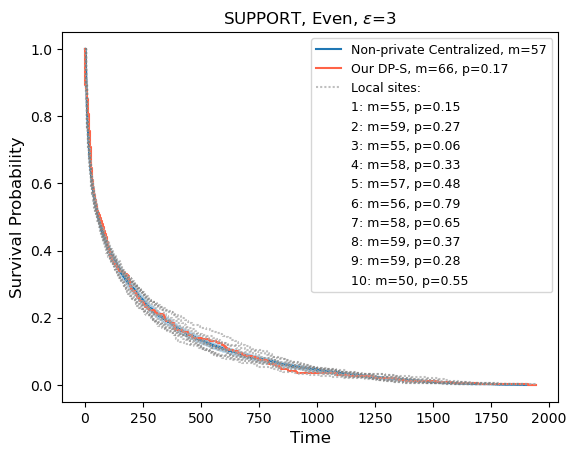

In [158]:
ax = plt.subplot(111)

m = plots.median(df)
kmf = KaplanMeierFitter()
a = kmf.fit(df["duration"], df["event"], label=f"Non-private Centralized, m={m}")
a.plot(color="#1f77b4")

m = ev.median(dspooled_surr)
p = ev.pvalue(df, dspooled_surr)
kmp = kmf.fit(dspooled_surr["duration"], dspooled_surr["event"], label=f"Our DP-S, m={m}, p={p}")
kmp.plot(ci_force_lines=False, ci_show=False, color="tomato", linestyle="-")

# m = ev.median(dpmatrix_surr)
# p = ev.pvalue(df, dpmatrix_surr)
# kmp = kmf.fit(dpmatrix_surr["duration"], dpmatrix_surr["event"], label=f"Our DP-S, m={m}, p={p}")
# kmp.plot(ci_force_lines=False, ci_show=False, color="tomato", linestyle="-")

kmo = kmf.fit(data_split[1]["duration"], data_split[1]["event"], label=f'Local sites:')
kmo.plot(ci_force_lines=False, ci_show=False, linestyle=(0, (1, 1)), color="grey", alpha=0.5)

for i in range(num_client):
    m = ev.median(data_split[i])
    p = ev.pvalue(df, data_split[i])
    if (percent_one>0 and i == 0):
        kmo = kmf.fit(data_split[i]["duration"], data_split[i]["event"], label=f'minority: m={m}, p={p} ')
    else: 
        kmo = kmf.fit(data_split[i]["duration"], data_split[i]["event"], label=f'{i+1}: m={m}, p={p} ')
        
    kmo.plot(ci_force_lines=False, ci_show=False, linestyle=(0, (1, 1)), color="white", alpha=0.5)
#     kmo.plot(ci_force_lines=False, ci_show=False, linestyle="dashed")

for i in range(num_client):
    m = ev.median(data_split[i])
    p = ev.pvalue(df, data_split[i])
    if (percent_one >0 and i == 0):
        kmo = kmf.fit(data_split[i]["duration"], data_split[i]["event"], label=f'')
    else: 
        kmo = kmf.fit(data_split[i]["duration"], data_split[i]["event"], label=f'')
        
    kmo.plot(ci_force_lines=False, ci_show=False, linestyle=(0, (1, 1)), color="grey", alpha=0.5)
#     kmo.plot(ci_force_lines=False, ci_show=False, linestyle="dashed")

# kmp = kmf.fit(sdy["duration"], sdy["event"], label=f"")
# kmp.plot(ci_force_lines=False, ci_show=False, color="tomato", linestyle="-")

ax.set_title(f"{name.upper()}, {title}, $\epsilon$={epsilon}", fontsize="large")
ax.set_xlabel("Time", fontsize="large")
ax.set_ylabel("Survival Probability", fontsize="large")
# leg1 = ax.legend()
# ax.add_artist(leg1, prop={'size': 6})
# ax.legend(loc="lower left", prop={'size': 7.3})
ax.legend(loc="upper right", fontsize=9)
# ax.add_artist(leg2)
plt.savefig(f'figs/rc1-{name}-fed-{title2}-e{epsilon}.pdf', dpi=300, bbox_inches="tight")
plt.show()

In [76]:
dspooled_p, dspooled_m, dspooled_sr = [], [], []

In [77]:
print("DP-Surv Pooled:")    
for i in range(100): 
    dspooled_surr = fdk.fed_DPS_pooledData(df, num_client, dp_surv_bins[name], max_time, frac, epsilon, percent_one)
    p, m , sr = ev.centralized_ex(df, dspooled_surr, tarr)
    dspooled_p+=[p]
    dspooled_m+=[m]
    dspooled_sr+=[sr]
print("p-value:", ev.confidence_of_mean(dspooled_p))
print("median:", ev.confidence_of_mean(dspooled_m))
print("survival rates:", ev.confidence_of_mean(dspooled_sr))

DP-Surv Pooled:
p-value: (0.2, array([0.15, 0.24]))
median: (60.02, array([58.94, 61.16]))
survival rates: (array([0.14, 0.05, 0.01]), array([[0.14, 0.05, 0.01],
       [0.14, 0.05, 0.02]]))


In [78]:
dsavgs_p, dsavgs_m, dsavgs_sr = [], [], []

In [79]:
print("DP-Surv Average S:")    
for i in range(100): 
    dsavgs_surr, _, _ = fdk.fed_DPS_avgS(df, num_client, dp_surv_bins[name], max_time, frac, epsilon, percent_one)
    p, m , sr = ev.centralized_ex(df, dsavgs_surr, tarr)
    dsavgs_p+=[p]
    dsavgs_m+=[m]
    dsavgs_sr+=[sr]
print("p-value:", ev.confidence_of_mean(dsavgs_p))
print("median:", ev.confidence_of_mean(dsavgs_m))
print("survival rates:", ev.confidence_of_mean(dsavgs_sr))

DP-Surv Average S:
p-value: (0.19, array([0.15, 0.23]))
median: (59.78, array([58.76, 60.86]))
survival rates: (array([0.14, 0.05, 0.01]), array([[0.14, 0.05, 0.01],
       [0.14, 0.05, 0.01]]))


In [80]:
dsavgy_p, dsavgy_m, dsavgy_sr = [], [], []

In [81]:
print("DP-Surv Average y:")    
for i in range(100): 
    dsavgy_surr, _ = fdk.fed_DPS_avgy(df, num_client, dp_surv_bins[name], max_time, frac, epsilon, percent_one)
    p, m , sr = ev.centralized_ex(df, dsavgy_surr, tarr)
    dsavgy_p+=[p]
    dsavgy_m+=[m]
    dsavgy_sr+=[sr]
print("p-value:", ev.confidence_of_mean(dsavgy_p))
print("median:", ev.confidence_of_mean(dsavgy_m))
print("survival rates:", ev.confidence_of_mean(dsavgy_sr))

DP-Surv Average y:
p-value: (0.23, array([0.18, 0.27]))
median: (60.06, array([59.08, 61.06]))
survival rates: (array([0.14, 0.05, 0.01]), array([[0.14, 0.05, 0.01],
       [0.14, 0.05, 0.02]]))


In [59]:
dypooled_p, dypooled_m, dypooled_sr = [], [], []

In [60]:
print("DP-Prob Pooled:")    
for i in range(100): 
    dypooled_surr = fdk.fed_DPy_pooledData(df, num_client, dp_surv_bins[name], max_time, epsilon, percent_one)
    p, m , sr = ev.centralized_ex(df, dypooled_surr, tarr)
    dypooled_p+=[p]
    dypooled_m+=[m]
    dypooled_sr+=[sr]
print("p-value:", ev.confidence_of_mean(dypooled_p))
print("median:", ev.confidence_of_mean(dypooled_m))
print("survival rates:", ev.confidence_of_mean(dypooled_sr))

DP-Prob Pooled:
p-value: (0.0, array([0., 0.]))
median: (25.89, array([25.79, 25.99]))
survival rates: (array([0.6 , 0.28, 0.11]), array([[0.6 , 0.28, 0.11],
       [0.6 , 0.28, 0.11]]))


In [61]:
dyavgs_p, dyavgs_m, dyavgs_sr = [], [], []

In [62]:
print("DP-Prob Average S:")    
for i in range(100): 
    dyavgs_surr, _, _ = fdk.fed_DPy_avgS(df, num_client, dp_surv_bins[name], max_time, epsilon, percent_one)
    p, m , sr = ev.centralized_ex(df, dyavgs_surr, tarr)
    dyavgs_p+=[p]
    dyavgs_m+=[m]
    dyavgs_sr+=[sr]
print("p-value:", ev.confidence_of_mean(dyavgs_p))
print("median:", ev.confidence_of_mean(dyavgs_m))
print("survival rates:", ev.confidence_of_mean(dyavgs_sr))

DP-Prob Average S:
p-value: (0.0, array([-0.,  0.]))
median: (25.99, array([25.9 , 26.08]))
survival rates: (array([0.6 , 0.28, 0.11]), array([[0.6 , 0.28, 0.11],
       [0.6 , 0.28, 0.11]]))


In [63]:
dyavgy_p, dyavgy_m, dyavgy_sr = [], [], []

In [64]:
print("DP-Prob Avgerage y:")    
for i in range(100): 
    dyavgy_surr, _ = fdk.fed_DPy_avgy(df, num_client, dp_surv_bins[name], max_time, epsilon, percent_one)
    p, m , sr = ev.centralized_ex(df, dyavgy_surr, tarr)
    dyavgy_p+=[p]
    dyavgy_m+=[m]
    dyavgy_sr+=[sr]
print("p-value:", ev.confidence_of_mean(dyavgy_p))
print("median:", ev.confidence_of_mean(dyavgy_m))
print("survival rates:", ev.confidence_of_mean(dyavgy_sr))

DP-Prob Avgerage y:
p-value: (0.0, array([-0.,  0.]))
median: (26.02, array([25.94, 26.1 ]))
survival rates: (array([0.6 , 0.28, 0.11]), array([[0.6 , 0.28, 0.11],
       [0.6 , 0.28, 0.12]]))


In [13]:
dpmatrix_p, dpmatrix_m, dpmatrix_sr = [], [], []

In [14]:
print("DP-Matrix pooled")
for i in range(100): 
    dpmatrix_surr = fdk.fed_DPMatrix_pooledData(df, num_client, dp_surv_bins[name], max_time, epsilon, percent_one)
    p, m , sr = ev.centralized_ex(df, dpmatrix_surr, tarr)
    dpmatrix_p+=[p]
    dpmatrix_m+=[m]
    dpmatrix_sr+=[sr]
print("p-value:", ev.confidence_of_mean(dpmatrix_p))
print("median:", ev.confidence_of_mean(dpmatrix_m))
print("survival rates:", ev.confidence_of_mean(dpmatrix_sr))

DP-Matrix pooled
p-value: (0.0, array([0., 0.]))
median: (170.88, array([169.42, 172.3 ]))
survival rates: (array([0.22, 0.02, 0.02]), array([[0.21, 0.02, 0.02],
       [0.22, 0.03, 0.03]]))


## Hyperparameter Selection

##### for DP-Y

In [94]:
#import datasets
# name = "SUPPORT"
df_init = gbsg.read_df()
_, df = h.event_seperator(df_init) #only non-censored points
max_duration = (df["duration"].max())
print(f'max duration: {max_duration}')
total_number = len(df)
print(f'total number of data points: {total_number}')

max duration: 83.0554428100586
total number of data points: 1267


In [95]:
epsilon = 1
bin_length = 6
max_time = math.floor(max_duration)

In [96]:
point1 = ((0.25 * max_duration) // bin_length) * bin_length
point2 = ((0.50 * max_duration) // bin_length) * bin_length
point3 = ((0.75 * max_duration) // bin_length) * bin_length

tarr = [point1, point2, point3]

In [97]:
#info of original dataset
survival, upper, lower = ev.confidence_at_time(df, tarr)
median, median_ci = ev.median_confidence(df)
print("survival at times:", survival)
print("upper confidence:", upper)
print("lower confidence:", lower)
print("median:", median, "median_ci:", median_ci)

survival at times: [0.63 0.31 0.09]
upper confidence: [0.65, 0.34, 0.11]
lower confidence: [0.6, 0.28, 0.08]
median: 24 median_ci: [[ 0.5        22.07802963 25.26488686]]


In [98]:
cmd1 = []
p1 = []

In [99]:
for i in np.arange(100):
    x = cdp.CentralizedDPy(df, bin_length, max_time, epsilon)
    surr, _, _, _ = x.DP_probs()
    # surr_func = cdp._dp_probs(df, bin_length, max_time, epsilon)
    p, cmd = ev.hyperparameter_ex(df, surr)
    p1 += [p]
    cmd1 += [cmd]

In [100]:
# average cmd and average p-value over 5 runs
print(f'cmd: {np.around(np.mean(cmd1), 2)}')
print(f'p-value: {np.around(np.mean(p1), 2)}')

cmd: 0.16
p-value: 0.0


##### DP - Matrix

In [161]:
#import datasets
df_init = metabric.read_df()
_, df = h.event_seperator(df_init) #only non-censored points
max_duration = (df["duration"].max())
print(f'max duration: {max_duration}')
total_number = len(df)
print(f'total number of data points: {total_number}')

max duration: 355.20001220703125
total number of data points: 1103


In [176]:
epsilon = 1
bin_length = 6
max_time = math.floor(max_duration)

In [177]:
cmd1 = []
p1 = []

In [178]:
for i in np.arange(100):
    surr, _ = cdp.DP_matrix(df, bin_length, max_time, epsilon)
    p, cmd = ev.hyperparameter_ex(df, surr)
    p1 += [p]
    cmd1 += [cmd]

In [179]:
# average cmd and average p-value over 5 runs
print(f'cmd: {np.around(np.mean(cmd1), 2)}')
print(f'p-value: {np.around(np.mean(p1), 2)}')

cmd: 0.04
p-value: 0.39


##### for DP-Surv

In [28]:
#import datasets
# name = "SUPPORT"
df_init = metabric.read_df()
_, df = h.event_seperator(df_init) #only non-censored points
max_duration = (df["duration"].max())
print(f'max duration: {max_duration}')
total_number = len(df)
print(f'total number of data points: {total_number}')

max duration: 355.20001220703125
total number of data points: 1103


In [29]:
epsilon = 1
bin_length = 6
max_time = math.floor(max_duration)

In [30]:
point1 = ((0.25 * max_duration) // bin_length) * bin_length
point2 = ((0.50 * max_duration) // bin_length) * bin_length
point3 = ((0.75 * max_duration) // bin_length) * bin_length

tarr = [point1, point2, point3]

In [31]:
survival, upper, lower = ev.confidence_at_time(df, tarr)
median, median_ci = ev.median_confidence(df)
print("survival at times:", survival)
print("upper confidence:", upper)
print("lower confidence:", lower)
print("median:", median, "median_ci:", median_ci)

survival at times: [0.51 0.17 0.02]
upper confidence: [0.54, 0.19, 0.03]
lower confidence: [0.48, 0.14, 0.01]
median: 86 median_ci: [[ 0.5        80.73332977 90.1333313 ]]


In [32]:
cmd1, cmd2, cmd3, cmd4 = [], [], [], []
p1, p2, p3, p4 = [], [], [], []

In [33]:
for i in np.arange(100):    
    c1 = cdp.CentralizedDPS(df, bin_length, max_time, 0.05, epsilon)
    surr1, _, _, _ = c1.DP_Surv()
    p, cmd = ev.hyperparameter_ex(df, surr1)
    p1 +=[p]
    cmd1 +=[cmd]

    c2 = cdp.CentralizedDPS(df, bin_length, max_time, 0.1, epsilon)
    surr2, _, _, _ = c2.DP_Surv()
    p, cmd = ev.hyperparameter_ex(df, surr2)
    p2 += [p]
    cmd2 += [cmd]

    c3 = cdp.CentralizedDPS(df, bin_length, max_time, 0.15, epsilon)
    surr3, _, _, _ = c3.DP_Surv()
    p, cmd = ev.hyperparameter_ex(df, surr3)
    p3 += [p]
    cmd3 += [cmd]

    c4 = cdp.CentralizedDPS(df, bin_length, max_time, 0.20, epsilon)
    surr4, _, _, _ = c4.DP_Surv()
    p, cmd = ev.hyperparameter_ex(df, surr4)
    p4 += [p]
    cmd4 += [cmd]


In [34]:
# average cmd and average p-value over 5 runs
print(f'5%: {np.around(np.mean(cmd1), 2)}')
print(f'10%: {np.around(np.mean(cmd2), 2)}')
print(f'15%: {np.around(np.mean(cmd3), 2)}')
print(f'20%: {np.around(np.mean(cmd4), 2)}')

5%: 0.19
10%: 0.02
15%: 0.04
20%: 0.04


In [35]:
# average cmd and average p-value over 5 runs
print(f'5%: {np.around(np.mean(p1), 2)}')
print(f'10%: {np.around(np.mean(p2), 2)}')
print(f'15%: {np.around(np.mean(p3), 2)}')
print(f'20%: {np.around(np.mean(p4), 2)}')

5%: 0.38
10%: 0.26
15%: 0.21
20%: 0.25


## RECONSTRUCTION EXPS

In [12]:
#import datasets
# name = "metabric"
df_init = gbsg.read_df()
_, df = h.event_seperator(df_init)
max_duration = (df["duration"].max())
print(f'max duration: {max_duration}')
total_number = len(df)
print(f'total number of data points: {total_number}')

max duration: 83.0554428100586
total number of data points: 1267


In [13]:
bin_length = 6
max_time = math.floor(max_duration)
surr_num = round(max_time / bin_length)

In [14]:
point1 = ((0.25 * max_duration) // bin_length) * bin_length
point2 = ((0.50 * max_duration) // bin_length) * bin_length
point3 = ((0.75 * max_duration) // bin_length) * bin_length

tarr = [point1, point2, point3]

In [15]:

p, cmd = ev.recons_ex(df, bin_length, max_time, round(2*total_number))
print(f'for n ={2*total_number}, cmd={cmd}, p={p}')

p, cmd = ev.recons_ex(df, bin_length, max_time, round(total_number))
print(f'for n ={total_number}, cmd={cmd}, p={p}')

p, cmd = ev.recons_ex(df, bin_length, max_time, round(0.5*total_number))
print(f'for n ={0.5*total_number}, cmd={cmd}, p={p}')


for n =2534, cmd=0.25, p=0.0
for n =1267, cmd=0.25, p=0.0
for n =633.5, cmd=0.25, p=0.0


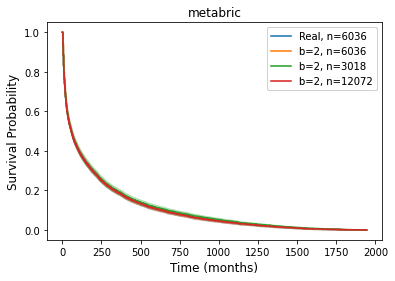

In [117]:
ax = plt.subplot(111)

kmf = KaplanMeierFitter()
ax = kmf.fit(df["duration"], df["event"], label=f"Real, n={total_number}").plot()
m = round(kmf.median_survival_time_)

ax = kmfr1.plot()
ax = kmfr2.plot()
# ax = kmfr3.plot()
ax = kmfr4.plot()

ax.set_title(name)
ax.set_xlabel("Time (months)", fontsize="large")
ax.set_ylabel("Survival Probability", fontsize="large")
leg1 = ax.legend()
# leg2 = ax.legend([f"m={m}, p=1", f"m={m1}, p={p1}", f"m={m2}, p={p2}" , f"m={m3}, p={p3}", f"m={m4}, p={p4}"], loc="lower left")
ax.add_artist(leg1)
# ax.add_artist(leg2)
# plt.savefig(f'{name}-reconstruct-bin{bins_length}.pdf', dpi=300)
plt.show()

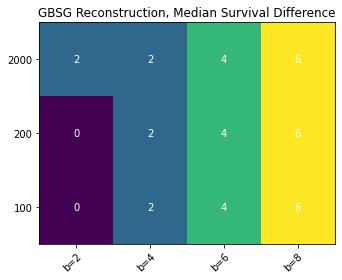

In [18]:
# heatmapplot
# https://matplotlib.org/3.4.3/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py
bins = ["b=2", "b=4", "b=6", "b=8"]
# frac = ["5%", "10%", "15%", "20%"]
frac = ["2000", "200", "100"]
valm = np.array([[52, 52, 54, 56], 
                 [50, 52, 54, 56], 
                 [50, 52, 54, 56] 
                ])
valm = valm -50
valp = np.array([[0.49, 0.15, 0.03, 0.01], 
                 [0.84, 0.65, 0.44, 0.39], 
                 [0.84, 0.64, 0.44, 0.39]
    
])
fig, ax = plt.subplots()
im = ax.imshow(valm)
# orig_map=plt.cm.get_cmap('viridis')
# reversed_map = orig_map.reversed()
# im = ax.imshow(valp, cmap = reversed_map)

ax.set_xticks(np.arange(len(bins)))
ax.set_yticks(np.arange(len(frac)))
# ... and label them with the respective list entries
ax.set_xticklabels(bins)
ax.set_yticklabels(frac)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
# Loop over data dimensions and create text annotations.
for i in range(len(frac)):
    for j in range(len(bins)):
        text = ax.text(j, i, valm[i, j],
                       ha="center", va="center", color="w")

ax.set_title(f'{name} Reconstruction, Median Survival Difference')
fig.tight_layout()
# plt.savefig(f'figs/{name}-m-reconstruct.pdf', dpi=300, bbox_inches="tight")
plt.show()
